# Nested Models

---

In grama, models are first-class objects: We can pass and manipulate models as *inputs*. This means we can build *nested* models to represent analysis procedures like double-loop Monte Carlo. This notebook demonstrates the idea.

In [1]:
import grama as gr

### Inner Model: Distribution

---

First we define an "inner model"; a very simple distribution.

In [2]:
md_inner = gr.Model("Inner") >> \
    gr.cp_marginals(
        x0=dict(
            dist="norm",
            loc=0,
            scale=1
        )
    ) >> \
    gr.cp_copula_independence()


We can use this model to simulate draws from a normal distribution.

Calling plot_scattermat....


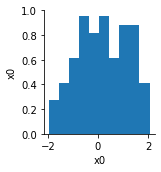

In [3]:
md_inner >> \
    gr.ev_monte_carlo(df_det="nom", n=100, skip=True) >> \
    gr.pt_auto()


### Outer Loop

---

However, we can also use `md_inner` as an input to *another* model to create a nested model. We will do this in order to perform *double-loop Monte Carlo*, where we first sample a parameter value (in our case the `scale`) in the outer loop, then sample `x0` conditional on that parameter value in the inner loop.


In [4]:
def fun_sample(x):
    scale, md = x
    
    df_res = md >> \
        gr.cp_marginals(
            x0=dict(
                dist="norm",
                loc=0,
                scale=scale
            )
        ) >> \
        gr.ev_monte_carlo(df_det="nom", skip=True)
    
    return df_res.x0

md_outer = gr.Model("Outer") >> \
    gr.cp_function(
        fun=fun_sample,
        var=["scale", "md"],
        out=["x0"]
    ) >> \
    gr.cp_marginals(
        scale=dict(
            dist="chi2",
            loc=1,
            scale=1,
            df=2
        )
    ) >> \
    gr.cp_copula_independence()


Now let's perform double-loop Monte Carlo, and analyze the results:

Calling plot_hists....


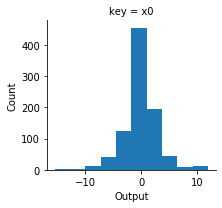

In [5]:
df_res = md_outer >> \
    gr.ev_monte_carlo(
        df_det=gr.df_make(md=[md_inner] * 30),
        n=30
    ) 
df_res >> \
    gr.pt_auto()


We can see the results are *far* more variable, due to the parametric uncertainty. Additionally, we can construct a scatterplot matrix to see the double-loop structure of the results.


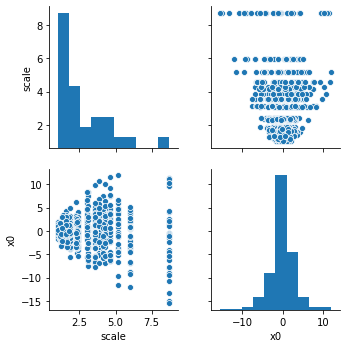

In [6]:
df_res >> gr.pt_scattermat(var=["scale", "x0"])


We can see there are 10 samples in `x0` per value of `scale`, and that the spread between points in `x0` increases as `scale` increases.
